### Need to get the corrected discharge params first

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.nonparametric.smoothers_lowess import lowess
import geopandas as gpd
import matplotlib
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from matplotlib import gridspec

from scipy.optimize import curve_fit
# viz params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']
sns.set_style('whitegrid')

y_test = pd.read_csv("/Users/jakegearon/CursorProjects/based/data/train_test/based_us_ytest_data_sans_trampush.csv", usecols=["depth"]).astype(float)
X_test = pd.read_csv("/Users/jakegearon/CursorProjects/based/data/train_test/based_us_Xtest_data_sans_trampush.csv")
trampush_csv = pd.read_csv("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdatercsv.csv").dropna(subset=["RA_dis_m3_pmx_2", "Qbf [m3/s]"])
trampush_csv = trampush_csv.query("Location != 'Ditch Run near Hancock'")
trampush_csv = trampush_csv.query("Location != 'Potomac River Tribuatary near Hancock. Md.'")
trampush_csv = trampush_csv.query("Location != 'Clark Fork tributary near Drummond'")
trampush_csv = trampush_csv.query("Location != 'Richards Creek near Libby MT'")
trampush_csv = trampush_csv.query("Location != 'Ohio Brush Creek near West Union'")
trampush_csv = trampush_csv[trampush_csv["Location"] != "Floyd's Fork at Fisherville"]
xgb_reg = xgb.XGBRegressor()
xgb_reg.load_model("/Users/jakegearon/CursorProjects/based/based/models/based_us_sans_trampush_early_stopping_combat_overfitting.ubj")
def power_law(x, a, b):
    return a * (x ** b)

x_data = trampush_csv['Qbf [m3/s]'].values
y_data = trampush_csv['RA_dis_m3_pmx_2'].values
params, covariance = curve_fit(power_law, x_data, y_data)
min_val = min(trampush_csv['Qbf [m3/s]'].min(), trampush_csv['RA_dis_m3_pmx_2'].min())
max_val = max(trampush_csv['Qbf [m3/s]'].max(), trampush_csv['RA_dis_m3_pmx_2'].max())
x_fit = np.linspace(min_val, max_val, 100)
y_fit = power_law(x_fit, *params)
#save params to file
import pickle
with open('/Users/jakegearon/CursorProjects/based/data/inverted_discharge_params.pickle', 'wb') as f:
    pickle.dump(params, f)
def inverse_power_law(y, a, b):
    return (y / a) ** (1 / b)
trampush_csv['corrected_discharge'] = inverse_power_law(trampush_csv['RA_dis_m3_pmx_2'], *params)
# change guesswork1 columns to match the columns in the model
guessworkRA = trampush_csv[['Wbf [m]', 'S [-]', 'RA_dis_m3_pmx_2']].astype(float)
guessworkRA.columns = ['width', 'slope', 'discharge']
trampush_csv['XGB_depth_RA'] = xgb_reg.predict(guessworkRA)
depth_predictions = pd.Series(xgb_reg.predict((X_test[['width', 'slope', 'discharge']]))).astype(float)
# Prepare input data for prediction
guessworkM = trampush_csv[['Wbf [m]', 'S [-]', 'Qbf [m3/s]']].astype(float)
guessworkM.columns = ['width', 'slope', 'discharge']
trampush_csv['XGB_depth_M'] = xgb_reg.predict(guessworkM)
guessworkRA_corr = trampush_csv[['Wbf [m]', 'S [-]', 'corrected_discharge']].astype(float)
guessworkRA_corr.columns = ['width', 'slope', 'discharge']
trampush_csv['XGB_depth_RA_corr'] = xgb_reg.predict(guessworkRA_corr)


#### Might as well plot this supplemental figure first

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


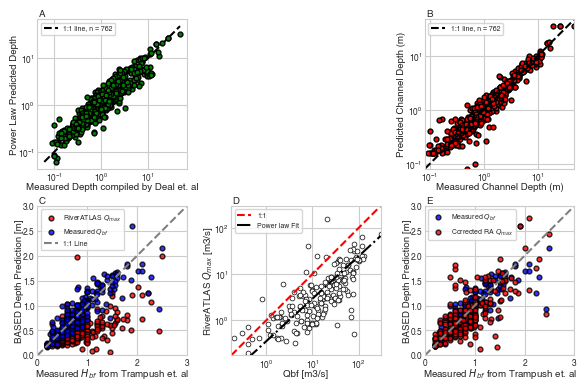

In [3]:
# Define marker size variable
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']
marker_size = 12

# Create subplots
# fig, axs = plt.subplots(2, 3, figsize=(7.5, 5), constrained_layout=True)
# axs = axs.ravel()

fig = plt.figure(figsize=(7, 4), constrained_layout=False)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# Create subplots in desired positions
axs = []
axs.append(fig.add_subplot(gs[0, 0]))  # Top left
axs.append(fig.add_subplot(gs[0, 2]))  # Top right
axs.append(fig.add_subplot(gs[1, 0]))  # Middle bottom left
axs.append(fig.add_subplot(gs[1, 1]))  # Middle bottom center
axs.append(fig.add_subplot(gs[1, 2]))  # Middle bottom right

# Load data
ytest = pd.read_csv("/Users/jakegearon/CursorProjects/based/data/train_test/based_us_ytest_data_sans_trampush.csv")
Xtest = pd.read_csv("/Users/jakegearon/CursorProjects/based/data/train_test/based_us_Xtest_data_sans_trampush.csv")
# # Ensure ytest is a Series
if isinstance(ytest, pd.DataFrame):
    ytest = ytest.iloc[:, 1]  # Take the first column assuming ytest DataFrame has a single column
# Calculate pred_depth
pred_depth = 0.31 * Xtest['discharge'] ** 0.38
axs[0].grid(zorder=0)
axs[0].scatter(ytest, pred_depth, color='green', edgecolor='k', s=12, zorder=3)
# Calculate common limits
common_min = min(pred_depth.min(), ytest.min())
common_max = max(pred_depth.max(), ytest.max())
axs[0].plot([common_min, common_max], [common_min, common_max], 'k--', lw=1.5, label=f'1:1 line, n = {len(ytest)}')
axs[0].set_xlabel('Measured Depth compiled by Deal et. al', fontsize=7)
axs[0].set_ylabel('Power Law Predicted Depth', fontsize=7)
axs[0].grid(True)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].text(0.01, 1.02, 'A', transform=axs[0].transAxes, size=7, weight='bold')

# Scatter plot for predicted vs actual values
axs[1].scatter(y_test, depth_predictions, color='red', edgecolor='k', s=marker_size)
axs[1].set_xlabel('Measured Channel Depth (m)', fontsize=7)
axs[1].set_ylabel('Predicted Channel Depth (m)', fontsize=7)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
min_val, max_val = min(min(y_test.values), min(depth_predictions.values)), max(max(y_test.values), max(depth_predictions.values))
axs[1].set_xlim(min_val, max_val)
axs[1].set_ylim(min_val, max_val)
# After setting your limits, you can extract these values
xlims = axs[1].get_xlim()
ylims = axs[1].get_ylim()
# Get minimum and maximum values considering both x and y limits
common_min = max(min(xlims), min(ylims))  # Using 'max' here to consider the highest minimum value
common_max = min(max(xlims), max(ylims))  # Using 'min' here to consider the lowest maximum value
# Now plot the line with these values
axs[1].plot([common_min, common_max], [common_min, common_max], 'k--', label=f'1:1 line, n = {len(y_test)}', lw=1.5)
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend()
axs[1].text(0.01, 1.02, 'B', transform=axs[1].transAxes, size=7, weight='bold')


# Scatter plot for the first subplot
axs[2].scatter(trampush_csv['Hbf [m]'], trampush_csv['XGB_depth_RA'], alpha=0.8, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$', s=marker_size)
axs[2].scatter(trampush_csv['Hbf [m]'], trampush_csv['XGB_depth_M'], alpha=0.8, c='b', edgecolor='k', label='Measured $Q_{bf}$', s=marker_size)
axs[2].plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
axs[2].set_xlabel('Measured $H_{bf}$ from Trampush et. al', fontsize=7)
axs[2].set_ylabel('BASED Depth Prediction [m]', fontsize=7)
axs[2].grid(True)
axs[2].set_xlim(0, 3)
axs[2].set_ylim(0, 3)
axs[2].legend()
axs[2].set_xlim(0, 3)
axs[2].set_ylim(0, 3)
axs[2].set_aspect('equal', adjustable='box')
axs[2].text(0.01, 1.02, 'C', transform=axs[2].transAxes, size=7, weight='bold')

# Scatter plot for the second subplot
axs[3].scatter(trampush_csv['Qbf [m3/s]'], trampush_csv['RA_dis_m3_pmx_2'], s=marker_size, color='w', edgecolor='k', linewidth=0.5)
min_val = min(trampush_csv['Qbf [m3/s]'].min(), trampush_csv['RA_dis_m3_pmx_2'].min())
max_val = max(trampush_csv['Qbf [m3/s]'].max(), trampush_csv['RA_dis_m3_pmx_2'].max())
axs[3].set_xlim(min_val, max_val)
axs[3].set_ylim(min_val, max_val)
axs[3].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1')
axs[3].set_xlabel('Qbf [m3/s]', fontsize=7)
axs[3].set_ylabel('RiverATLAS $Q_{max}$ [m3/s]', fontsize=7)
axs[3].grid(True)
axs[3].set_aspect('equal', adjustable='box')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].text(0.01, 1.02, 'D', transform=axs[3].transAxes, size=7, weight='bold')
axs[3].plot(x_fit, y_fit, color='black', ls='-.', label='Power law Fit')
axs[3].legend()

# Create a new subplot for the corrected values scatter plot
axs[4].scatter(trampush_csv['Hbf [m]'], trampush_csv['XGB_depth_M'], alpha=0.8, c='b', edgecolor='k', label='Measured $Q_{bf}$', s=marker_size)
axs[4].scatter(trampush_csv['Hbf [m]'], trampush_csv['XGB_depth_RA_corr'], alpha=0.8, c='r', edgecolor='k', label='Corrected RA $Q_{max}$', s=marker_size)
axs[4].plot([0, 3], [0, 3], linestyle='--', color='gray')
axs[4].set_xlabel('Measured $H_{bf}$ from Trampush et. al', fontsize=7)
axs[4].set_ylabel('BASED Depth Prediction [m]', fontsize=7)
axs[4].grid(True)
axs[4].legend()
axs[4].set_xlim(0, 3)
axs[4].set_ylim(0, 3)
axs[4].set_aspect('equal', adjustable='box')
axs[4].text(0.01, 1.02, 'E', transform=axs[4].transAxes, size=7, weight='bold')

plt.subplots_adjust(top=0.95, wspace=0.25, hspace=0.25)

# Adjust layout
for ax in axs:
    ax.legend(fontsize=5)
    ax.tick_params(axis='both', labelsize=6, pad=-1.5)

    # Adjust label padding for x and y labels by -2
    ax.set_xlabel(ax.get_xlabel(), labelpad=-.8)
    ax.set_ylabel(ax.get_ylabel(), labelpad=-.8)

# Save the figure
plt.savefig("/Users/jakegearon/CursorProjects/walker/trampush_discharge.png", dpi=300, bbox_inches='tight')
plt.savefig("/Users/jakegearon/CursorProjects/walker/trampush_discharge.pdf")

# Show the figure
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
# Calculate metrics
r2 = r2_score(y_test, depth_predictions)
rmse = mean_squared_error(y_test, depth_predictions, squared=False)
mae = mean_absolute_error(y_test, depth_predictions)
mape = mean_absolute_percentage_error(y_test, depth_predictions)
# Print metrics
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


R2: 0.89346495096274
RMSE: 1.0237030748093285
MAE: 0.32706223200059215
MAPE: 0.1956675176829661


In [4]:
r2 = r2_score(y_test, pred_depth)
rmse = mean_squared_error(y_test, pred_depth, squared=False)
mae = mean_absolute_error(y_test, pred_depth)
mape = mean_absolute_percentage_error(y_test, pred_depth)
# Print metrics
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R2: 0.8299557339185657
RMSE: 1.2933282047016441
MAE: 0.6361872663958414
MAPE: 0.35207926110978705


In [5]:
yytest = trampush_csv['Hbf [m]']
dd_pred = trampush_csv['XGB_depth_RA_corr']

r2 = r2_score(yytest, dd_pred)
rmse = mean_squared_error(yytest, dd_pred, squared=False)
mae = mean_absolute_error(yytest, dd_pred)
mape = mean_absolute_percentage_error(yytest, dd_pred)
# Print metrics
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R2: -0.044447707924283764
RMSE: 0.46889636453129707
MAE: 0.2797291725347138
MAPE: 0.3485233085166782


### Now load the measured data

In [6]:

# Load data
df = pd.read_excel('/Users/jakegearon/CursorProjects/walker/submission_data_final.xlsx')
# Filtering out unwanted avulsion names


# Preprocessing calculations
df['XV_mean'] = df[['sar1', 'sar2', 'sar3']].mean(axis=1)
df['parent_ar_slope_mean'] = df[['sm1', 'sm2', 'sm3']].mean(axis=1)
df['XS/DS'] = df['XV_mean'] / df['parent_ar_slope_mean']
df['sp'] = df['normalized_dist'] / df['parent_ar_slope_mean']

# Calculate the standard error for the mean of XV and parent_ar_slope
df['XV_mean_error'] = df[['XV1', 'XV2', 'XV3']].std(axis=1) / np.sqrt(3)
df['parent_ar_slope_mean_error'] = df[['parent_ar_slope1', 'parent_ar_slope2', 'parent_ar_slope3']].std(axis=1) / np.sqrt(3)

# Calculate gamma and its log-transform
df['log_gamma'] = np.log(df['XV_mean']) - np.log(df['parent_ar_slope_mean'])
df['gamma'] = np.exp(df['log_gamma'])

# Calculate the standard error of the log-transformed means
df['log_XV_mean_SE'] = df['XV_mean_error'] / df['XV_mean']
df['log_parent_ar_slope_mean_SE'] = df['parent_ar_slope_mean_error'] / df['parent_ar_slope_mean']

# Calculate the absolute error for gamma in the log domain and adjust for the back-transform
df['log_gamma_error'] = np.sqrt(df['log_XV_mean_SE']**2 + df['log_parent_ar_slope_mean_SE']**2)
df['gamma_error_upper'] = np.exp(df['log_gamma'] + df['log_gamma_error']) - df['gamma']

# Calculate the lower error and ensure it doesn't go below the minimum allowed value after back-transform
df['gamma_error_lower'] = np.maximum(df['gamma'] - np.exp(df['log_gamma'] - df['log_gamma_error']), 0.1)

# Calculate the relative errors adjusted for the log scale plot
yerr_upper_relative = df['gamma_error_upper'] / df['XS/DS']
yerr_lower_relative = df['XS/DS'] - np.maximum(df['XS/DS'] - df['gamma_error_lower'], 0.1)

# More processing calculations
df['aspect ratio'] = df['width'] / df['XGB_depth_mean']
df['wt_pc_schumm'] = (1 / (df['aspect ratio'] / 255))**(1/1.08)

# Load XGBoost model and make predictions
xgb_reg = xgb.XGBRegressor()
xgb_reg.load_model("/Users/jakegearon/CursorProjects/based/based/models/based_us_early_stopping_combat_overfitting.ubj")

# Apply the power-law correction to the discharge values
df['corrected_discharge'] = inverse_power_law(df['discharge_max'], *params)
guesswork_full = df[['width', 'parent_ar_slope_mean', 'corrected_discharge']].astype(float)
guesswork_full.columns = ['width', 'slope', 'discharge']
# Use the corrected discharge, width, and parent_ar_slope_mean to predict the depth
df['XGB_depth'] = xgb_reg.predict(guesswork_full)
df['XGB_depth'] = np.where(df['XGB_depth'] < 0, 0.1, df['XGB_depth'])
# More data transformations
df['alluvial_ridge_height1'] = df['alluvial_ridge_elevation1'] - df['floodplain_elevation1']
df['alluvial_ridge_height2'] = df['alluvial_ridge_elevation2'] - df['floodplain_elevation2']
df['alluvial_ridge_height3'] = df['alluvial_ridge_elevation3'] - df['floodplain_elevation3']

# Superelevation calculations
df['A'] = df[['alluvial_ridge_elevation1', 'alluvial_ridge_elevation2', 'alluvial_ridge_elevation3']].sub(df[['water_elevation1', 'water_elevation2', 'water_elevation3']].values).mean(axis=1)
df['B'] = df['XGB_depth']
# Assuming you have a DataFrame named 'df'

# Calculate 'A1' and 'B1' for the first set of columns (2)
df['A1'] = df['alluvial_ridge_elevation1'] - df['water_elevation1']
df['B1'] = df['XGB_depth']

# Calculate 'A2' and 'B2' for the second set of columns (3)
df['A2'] = df['alluvial_ridge_elevation2'] - df['water_elevation2']
df['B2'] = df['XGB_depth']

# Calculate 'A3' and 'B3' for the third set of columns (4)
df['A3'] = df['alluvial_ridge_elevation3'] - df['water_elevation3']
df['B3'] = df['XGB_depth']

# Find the mean of 'A' values (A1, A2, and A3) and 'B' values (B1, B2, and B3)
df['A'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['B'] = df[['B1', 'B2', 'B3']].mean(axis=1)

# Calculate A/B
df['A/B'] = abs(df['A']) / abs(df['B'])


# Masks for each category
mask1 = df['method_used2'] == 1
mask2 = df['method_used2'] == 2
mask3 = df['method_used2'] == 3

df.loc[mask1, 'se_max1'] = df['alluvial_ridge_height1'] / df['XGB_depth']
df.loc[mask1, 'se_max2'] = df['alluvial_ridge_height2'] / df['XGB_depth']
df.loc[mask1, 'se_max3'] = df['alluvial_ridge_height3'] / df['XGB_depth']


df.loc[mask2, 'se_max1'] = df['alluvial_ridge_height1'] / (df['alluvial_ridge_elevation1'] - (df['water_elevation1']))
df.loc[mask2, 'se_max2'] = df['alluvial_ridge_height2'] / (df['alluvial_ridge_elevation2'] - (df['water_elevation2']))
df.loc[mask2, 'se_max3'] = df['alluvial_ridge_height3'] / (df['alluvial_ridge_elevation3'] - (df['water_elevation3']))

# When A/B > 4
df.loc[mask3, 'se_max1'] = df['alluvial_ridge_height1'] / (df['alluvial_ridge_elevation1'] - (df['water_elevation1']-df['XGB_depth']))  # Fill this in with the relevant formula
df.loc[mask3, 'se_max2'] = df['alluvial_ridge_height2'] / (df['alluvial_ridge_elevation2'] - (df['water_elevation2']-df['XGB_depth']))  # Fill this in with the relevant formula
df.loc[mask3, 'se_max3'] = df['alluvial_ridge_height3'] / (df['alluvial_ridge_elevation3'] - (df['water_elevation3']-df['XGB_depth']))  # Fill this in with the relevant formula


df['se_std'] = df[['se_max1', 'se_max2', 'se_max3']].std(axis=1)
df['superelevation_ov_mean'] = df[['se_max1', 'se_max2', 'se_max3']].mean(axis=1)
df['superelevation_sem'] = df[['se_max1', 'se_max2', 'se_max3']].sem(axis=1) / 3

# Additional processing


df['Geomorphology'] = df['Geomorphology'].replace({'Mountain Front': 'Alluvial Plain'})

df['prod'] = df['superelevation_ov_mean'] * df['XS/DS']
df['AB_flag'] = np.abs(df['A']) > np.abs(df['B'])




KeyError: "None of [Index(['XV1', 'XV2', 'XV3'], dtype='object')] are in the [columns]"

### bootstrap uncertainty

In [7]:
n_simulations = 10000

ridge_elev_error = 0.6
floodplain_elev_error = 0.6
water_surface_elev_error = 0.25
xgb_depth_error = 1.0

superelevation_column = 'superelevation'
uncertainty_column = 'uncertainty'

for index, row in df.iterrows():
    all_superelevations = []

    for _ in range(n_simulations):
        i = np.random.choice([1, 2, 3])

        ridge_height = row[f'alluvial_ridge_elevation{i}'] - row[f'floodplain_elevation{i}']
        sampled_ridge_height = ridge_height + np.random.triangular(-ridge_elev_error, 0, ridge_elev_error)
        sampled_water_surface_elevation = row[f'water_elevation{i}'] + np.random.triangular(-water_surface_elev_error, 0, water_surface_elev_error)
        sampled_xgb_depth = row['XGB_depth'] + np.random.triangular(-xgb_depth_error, 0, xgb_depth_error)

        if row['method_used2'] == 1:
            superelevation = sampled_ridge_height / sampled_xgb_depth
        elif row['method_used2'] == 2:
            superelevation = sampled_ridge_height / (row[f'alluvial_ridge_elevation{i}'] - sampled_water_surface_elevation)
        elif row['method_used2'] == 3:
            superelevation = sampled_ridge_height / (row[f'alluvial_ridge_elevation{i}'] - (sampled_water_surface_elevation - sampled_xgb_depth))

        all_superelevations.append(superelevation)

    df.at[index, superelevation_column] = np.mean(all_superelevations)
    df.at[index, uncertainty_column] = np.std(all_superelevations)

boot_df = df  # Now df contains all the needed columns.



### only part of fig 1 is computed with code

174
174


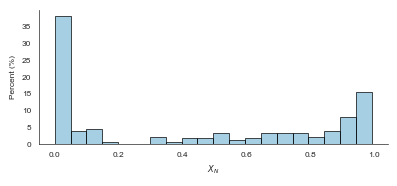

In [8]:

df_hist = gpd.read_file('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/pop_zonal.geojson')
df_hist = pd.read_csv('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/XN_hist_data.csv')
df_hist['normalized_dist'] = df_hist['normalized_dist'].astype(float)
print(len(df_hist))
print(len(df_hist['normalized_dist'].dropna()))

# Set font size and style
sns.set(font_scale=1.0, style="white")

# Create figure and axes
fig, ax = plt.subplots(figsize=(4.5, 1.75))

# Plot histogram
sns.histplot(data=df_hist, x='normalized_dist', kde=False, fill=True,
             alpha=.5, edgecolor='black', stat="percent", binwidth=.05, color='#4FA0CA',linewidth=.50)

# Set axis labels and title
ax.set_xlabel('$X_N$', fontsize=6)
ax.set_ylabel('Percent (%)', fontsize=6)

ax.tick_params(axis='both', which='major', labelsize=6, width=0, length=2)
ax.spines['bottom'].set_linewidth(0.5)  # Adjust the line width of the x-axis
ax.spines['left'].set_linewidth(0.5)    # Adjust the line width of the y-axis
sns.despine()

## Fig 2

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


meanprops = {
    "marker": "D",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "3",
    "markeredgewidth": 0.25
}

flierprops = {
    "marker": "^",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "3",
    "markeredgewidth": 0.5
}
fontsize = 7
#palette = [ '#90EE90', '#F5F5DC', '#ADD8E6']
#use standard color palette
palette = sns.color_palette("colorblind")
#palette = ['#00C853', '#EF6C00','#304FFE']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_scatter_with_lowess(ax, data, x_col, y_col, frac=1, len_boot=5000, color_data=None, palette=palette, edgecolor='black'):
    # Extract data from DataFrame
    x = data[x_col]
    y = np.log(data[y_col])  # Log-transform y values

    # If color_data is specified, use hue in scatterplot
    if color_data:
        sns.scatterplot(x=data[x_col], y=data[y_col], hue=data[color_data], s=20, ax=ax, palette=palette, hue_order=['Delta', 'Fan', 'Alluvial Plain'], edgecolor=edgecolor)
    else:
        sns.scatterplot(x=data[x_col], y=data[y_col], ax=ax)

    # Fit the LOWESS model to the log-transformed data
    lowess_results = lowess(y, x, frac=frac, it=5)
    y_predicted = lowess_results[:, 1]
    residuals = y - y_predicted

    # Perform bootstrapping to estimate the confidence intervals in log space
    y_bootstrapped = np.empty((len_boot, len(y)))
    for i in range(len_boot):
        residuals_bootstrap = resample(residuals)
        y_bootstrapped[i] = y_predicted + residuals_bootstrap

    # Calculate the lower and upper bounds of the confidence intervals in log space
    y_ci_lower = np.percentile(y_bootstrapped, 2.5, axis=0)
    y_ci_upper = np.percentile(y_bootstrapped, 97.5, axis=0)

    # Transform the predicted values and confidence intervals back to linear space for plotting
    y_predicted = np.exp(y_predicted)
    y_ci_lower = np.exp(y_ci_lower)
    y_ci_upper = np.exp(y_ci_upper)

    # Plot the LOWESS fit and the confidence intervals
    ax.plot(lowess_results[:, 0], y_predicted, color='red', linestyle='--', linewidth=1.)
    ax.fill_between(lowess_results[:, 0], y_ci_lower, y_ci_upper, color='lightgray', alpha=0.3)  # Lighter gray

    # Formatting and labeling
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend().set_visible(False)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

    return ax

# Then include the custom function before plotting:
def format_func(value, tick_number):
    return "{:.0f}".format(value)
    
def plot_boxplot(ax, x_data, y_data, order, ylabel=''):
    sns.boxplot(data=df, x=x_data, y=y_data, hue='Geomorphology', showfliers=False, flierprops=flierprops,
                showmeans=True, meanprops=meanprops,
                order=order, hue_order=['Delta', 'Fan', 'Alluvial Plain'], ax=ax, palette=palette, linewidth=0.5, width=0.75)

    ax.grid(axis='y', visible=True)
    ax.set_ylabel(ylabel, labelpad=10, rotation=0)
    labels = ax.get_xticklabels()
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(labels, fontsize=5, ha='center')
    

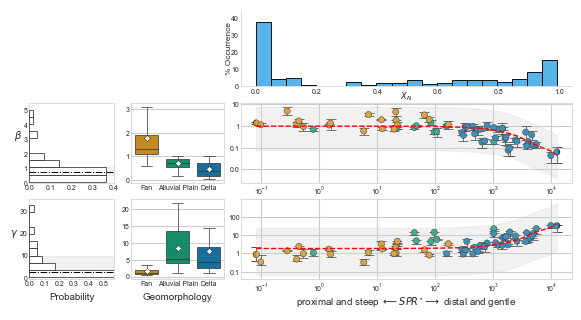

In [18]:
import matplotlib.ticker as ticker

# Custom formatter function
def custom_formatter(x, pos):
    # Check if the value is less than 1 and format it with an additional decimal place
    if x < 1:
        return '{:.1f}'.format(x)  # 1 decimal places for values less than 1
    elif x <= 0.1:
        return '{:.2f}'.format(x) # 2 decimal places for values less than .1
    elif x == 0:
        return '{:.0f}'.format(x)
    else:
        return '{:.0f}'.format(x)  # 0 decimal places for all other values
    
# Create a figure
fig_width, fig_height = 7, 3.5  # Adjusted width to accommodate the new column
fig = plt.figure(figsize=(fig_width, fig_height))

# Divide the figure into 7 rows and 3 columns
gs1 = gridspec.GridSpec(7, 3, width_ratios=[.5, .55, 1.95], height_ratios=[2.5, .5, .5, .5, .5, .5, .5], wspace=.10, hspace=.7)  # Updated width ratios

ax_new_hist = fig.add_subplot(gs1[0, 2:3])  
sns.histplot(data=df_hist, x='normalized_dist', kde=False, fill=True,
             alpha=1, edgecolor='black', stat="percent", binwidth=.05, color='#56b4e9', linewidth=.65, ax=ax_new_hist) #'#4FA0CA'
#ax_new_hist.grid(axis='y', which='major', color='gray', linestyle='-', linewidth=.5, visible=False)
ax_new_hist.grid(False)
ax_new_hist.set_ylim(0, 45)
# Set axis labels and title for the new histogram
ax_new_hist.set_xlabel('$X_N$', fontsize=6, labelpad=-3)
ax_new_hist.set_ylabel('% Occurrence', fontsize=6, labelpad=-.5)
ax_new_hist.tick_params(axis='both', which='major', labelsize=6, width=0, length=2)
sns.despine(ax=ax_new_hist)

# Scatter plots on the left
ax0 = fig.add_subplot(gs1[1:4, 2])

ax0.errorbar(boot_df['sp'], boot_df['superelevation'], yerr=boot_df['uncertainty'], capsize=3.5, capthick=0.5, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax0, df, 'sp', 'superelevation_ov_mean', color_data='Geomorphology', palette=palette)
ax0.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.set_xscale('log')


ax1 = fig.add_subplot(gs1[4:7, 2])
ax1.errorbar(df['sp'], df['XS/DS'], yerr=[yerr_lower_relative, yerr_upper_relative], capsize=3.5, capthick=0.5, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax1, df, 'sp', 'XS/DS', color_data='Geomorphology', palette=palette)
ax1.set_xlabel(r'proximal and steep $\longleftarrow SPR^{\star} \longrightarrow$ distal and gentle', fontsize=fontsize, labelpad=1)
ax1.set_xscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))



# Boxplots in the middle (unchanged)
ax3 = fig.add_subplot(gs1[1:4, 1])
plot_boxplot(ax3, 'Geomorphology', 'superelevation_ov_mean', ['Fan', 'Alluvial Plain', 'Delta'])
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4 = fig.add_subplot(gs1[4:7, 1])
plot_boxplot(ax4, 'Geomorphology', 'XS/DS', ['Fan', 'Alluvial Plain', 'Delta'])
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xlabel('Geomorphology', fontsize=fontsize)
# Histograms on the right (unchanged)
ax6 = fig.add_subplot(gs1[1:4, 0])
sns.histplot(data=df, y='superelevation', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax6, zorder=3, linewidth=.5)
ax6.set_ylabel(r'$\beta$', rotation=0, fontsize=fontsize)
ax6.set_yticks([0, 1, 2, 3, 4, 5])
ax6.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax6.grid(False)
ax6.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))



ax6.set_xlabel('')
ax6.axhspan(.5, 1.1, color='#BDBDBD', alpha=.2, fill=True, zorder=1)
ax6.set_ylim(0, 5.5)
median_superelevation = df['superelevation_ov_mean'].median()
ax6.axhline(y=median_superelevation, color='black', linestyle='-.', linewidth=.75, zorder=4)

ax7 = fig.add_subplot(gs1[4:7, 0])
ax7.grid(False)
sns.histplot(data=df, y='XS/DS', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax7, zorder=3, linewidth=.5)
ax7.set_ylabel(r'$\gamma$', rotation=0, fontsize=fontsize)
ax7.set_xlabel('Probability', fontsize=fontsize)
# Plotting the right histogram with shaded area
ax7.axhspan(3, 10, color='#BDBDBD', alpha=0.2, zorder=1)
ax7.set_ylim(-.5, 35)
median_XS_DS = df['XS/DS'].median()
ax7.axhline(y=median_XS_DS, color="black", linestyle='-.', linewidth=.75, zorder=4)
ax7.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax7.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))


all_axes = [ax_new_hist, ax0, ax1, ax3, ax4, ax6, ax7]
for ax in all_axes:
    for spine in ax.spines.values():
        spine.set_linewidth(.5)
    if ax == ax_new_hist:
        ax.tick_params(axis='both', labelsize=5, pad=-.2)
    else:
        ax.tick_params(axis='both', labelsize=5, pad=-3.5)



plt.margins(0, 0)
plt.savefig('FIGURE2.pdf')
plt.savefig('FIGURE2.png', dpi=300)
plt.show()


In [15]:
#stats for paper
len(df_hist['normalized_dist'].dropna())
# 175 total
len(df_hist[df_hist['normalized_dist']<.15])#['Geomorphology'].value_counts()
# # 81 within 15% of mtn front

len(df_hist[df_hist['normalized_dist']>.85])#['Geomorphology'].value_counts()
# # 48 within 15% of shoreline
(81+48)#/174*100

df.groupby('Geomorphology')['XS/DS'].mean()


Geomorphology
Alluvial Plain    8.569358
Delta             7.434026
Fan               1.561035
Name: XS/DS, dtype: float64

In [14]:
round(0.447824,1)

0.4

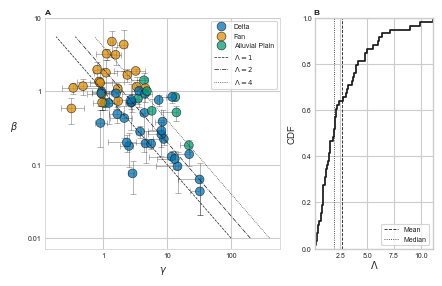

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import gmean

# Custom formatter function
def custom_formatter(x, pos):
    # Check if the value is less than 1 and format it with an additional decimal place
    if x < 1 and x >= 0.1:
        return '{:.1f}'.format(x)  # 1 decimal places for values less than 1
    elif x < 0.1 and x >= 0.01:
        return '{:.2f}'.format(x) # 2 decimal places for values less than .1
    elif x == 0:
        return '{:.0f}'.format(x)
    else:
        return '{:.0f}'.format(x)  # 0 decimal places for all other values

sns.set_context('paper', font_scale=1.0)
sns.set_style('whitegrid')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 5

fig = plt.figure(figsize=(5, 3))  # Adjusted width to accommodate the CDF
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0])  # For scatter and lines
ax0 = fig.add_subplot(gs[1])  # For CDF, share the y-axis with ax1

# Plot histogram on the top axis
sns.ecdfplot(data=df, x=df['XS/DS']*df['superelevation_ov_mean'], ax=ax0, color='k', linewidth=1.25)
ax0.set_xlabel(r'$\Lambda$', fontsize=7, labelpad=0) 
ax0.set_ylabel('CDF')
ax0.tick_params(axis='y', labelsize=5)  # No y-axis labels on the CDF
ax0.tick_params(axis='x', labelsize=5)
# Calculate the arithmetic mean, geometric mean, and median
arithmetic_mean = np.mean(df['XS/DS']*df['superelevation_ov_mean'])
geometric_mean_val = gmean(df['XS/DS']*df['superelevation_ov_mean'])
median_val = np.median(df['XS/DS']*df['superelevation_ov_mean'])

# Add vertical lines to the histogram
ax0.axvline(arithmetic_mean, color='k', linestyle='--', lw=0.6, label='Mean')
#ax0.axvline(geometric_mean_val, color='k', linestyle='-.', lw=0.6, label='Geometric Mean')
ax0.axvline(median_val, color='k', linestyle=':', lw=0.6, label='Median')

# Enhance legend to include new lines
ax0.legend(fontsize=5)

#ax0.set_xticks([])  # Remove xticks for the histogram
ax0.set_ylabel('CDF', fontsize=7)
ax0.tick_params(axis='both', labelsize=5, pad=-2)
ax1.errorbar(df['XS/DS'], df['superelevation_ov_mean'], yerr=boot_df['uncertainty'], xerr=[yerr_lower_relative, yerr_upper_relative], capsize=2.25, capthick=.4, ls='none', lw=.4, alpha=0.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
# Scatter plot
sns.scatterplot(data=df, x=df['XS/DS'], y='superelevation_ov_mean', hue='Geomorphology', hue_order=['Delta', 'Fan', 'Alluvial Plain'], s=40, edgecolor='k', ax=ax1, alpha=0.75, palette=palette)
# ax1.set_ylim(0, 5)
# ax1.set_xlim(0, 35)
# Define beta values
beta = np.linspace(0.01, 5.5, 100)
# Calculate and plot gamma_lambda for each theta value
thetas = [1, 2, 4]
colors = ['#003366', '#8B0000', '#4DB6AC']
lss = ['--', '-.', ':']
for i, theta in enumerate(thetas):
    gamma_lambda = (theta) / beta
    ax1.plot(gamma_lambda, beta, lw=.5, ls=lss[i], color='k', label=rf'$\Lambda = {theta}$')

ax1.grid()
ax1.legend(fontsize=5)
ax1.set_ylabel(r'$\beta$', fontsize=7, rotation=0, labelpad=10)
ax1.set_xlabel(r'$\gamma$', fontsize=7)
#ax1.set_xlim(-1, 35)

ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))


for spine in ax1.spines.values():
    spine.set_linewidth(.5)
ax1.tick_params(axis='both', labelsize=5, pad=-2)



ax0.text(.035, 1.035, 'B', transform=ax0.transAxes, 
         fontsize=6, fontweight='bold', va='top', ha='right')

# Label for the scatter plot
ax1.text(.025, 1.035, 'A', transform=ax1.transAxes, 
         fontsize=6, fontweight='bold', va='top', ha='right')

ax1.set_yticks([.01, 0.1, 1, 10])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
plt.tight_layout()
plt.margins(0, 0)
plt.savefig('FIGURE3_with_histogram.png', dpi=300)
plt.show()


In [ ]:
test = df[df['Geomorphology'] == 'Delta']['superelevation_ov_mean']
df_smaller = test[test < .5]
len(test)
len(df_smaller)
df['prod'].describe()


count    58.000000
mean      2.694643
std       2.463936
min       0.183767
25%       0.915068
50%       1.920124
75%       3.780281
max      11.136029
Name: prod, dtype: float64

/var/folders/hw/h57q1f8s5gb97km03v5w6xm40000gn/T/ipykernel_30916/3501042383.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  axs[0].plot(df_val['FABDEM'], intercept_height + slope_height * df_val['FABDEM'], 'r--', label='OLS', lw=.5, ls=':')


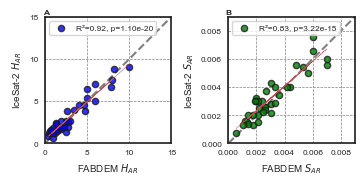

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

# Load your data
df_val = pd.read_excel('FABDEM_IS2_VAL.xlsx')

# Set the style for the plot
sns.set(style="white")

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(4, 2.0))

# Function to calculate r-squared and p-value
def calc_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2, p_value

# Plot for Alluvial Ridge Height
r2_height, p_height = calc_stats(df_val['FABDEM'], df_val['IS2'])
axs[0].scatter(df_val['FABDEM'], df_val['IS2'], alpha=0.8, c='blue', edgecolor='k', s=20, zorder=2)
axs[0].plot([0, 15], [0, 15], linestyle='--', color='gray', zorder=1)
slope_height, intercept_height = np.polyfit(df_val['FABDEM'], df_val['IS2'], 1)
axs[0].plot(df_val['FABDEM'], intercept_height + slope_height * df_val['FABDEM'], 'r--', label='OLS', lw=.5, ls=':')
axs[0].set_xlabel('FABDEM $H_{AR}$', fontsize=7)
axs[0].set_ylabel('IceSat-2 $H_{AR}$', fontsize=7)
axs[0].set_xticks([0, 5, 10, 15])
axs[0].set_yticks([0, 5, 10, 15])
axs[0].set_xlim(0, 15)
axs[0].set_ylim(0, 15)
axs[0].legend([f'R²={r2_height:.2f}, p={p_height:.2e}'], loc='upper left', frameon=True, fontsize=6)

# Plot for Alluvial Ridge Slope
r2_slope, p_slope = calc_stats(df_val['FABDEM_SLOPE'], df_val['IS2_SLOPE'])
axs[1].scatter(df_val['FABDEM_SLOPE'], df_val['IS2_SLOPE'], alpha=0.8, c='green', edgecolor='k', s=20, zorder=2)
axs[1].plot([0, .009], [0, .009], linestyle='--', color='gray', zorder=1)
slope_slope, intercept_slope = np.polyfit(df_val['FABDEM_SLOPE'], df_val['IS2_SLOPE'], 1)
axs[1].plot(df_val['FABDEM_SLOPE'], intercept_slope + slope_slope * df_val['FABDEM_SLOPE'], 'r', label='OLS', lw=.5, ls=':')
axs[1].set_xlabel('FABDEM $S_{AR}$', fontsize=7)
axs[1].set_ylabel('IceSat-2 $S_{AR}$', fontsize=7)
axs[1].set_xticks([0, .002, .004, .006, .008])
axs[1].set_yticks([0, .002, .004, .006, .008])
axs[1].set_xlim(0, .009)
axs[1].set_ylim(0, .009)
axs[1].legend([f'R²={r2_slope:.2f}, p={p_slope:.2e}'], loc='upper left', frameon=True, fontsize=6)

# Adjust layout
plt.subplots_adjust(wspace=0.45)
for ax in axs:
    ax.grid(True, linestyle='--', color='grey', lw=0.5, zorder=0)
    ax.tick_params(axis='both', which='major', labelsize=6, pad=-1.5)
    ax.set_aspect('equal', 'box')
    
axs[0].text(.038, 1.06, 'A', transform=axs[0].transAxes, 
         fontsize=6, fontweight='bold', va='top', ha='right')

# Label for the scatter plot
axs[1].text(.028, 1.06, 'B', transform=axs[1].transAxes, 
         fontsize=6, fontweight='bold', va='top', ha='right')

# Save the figure
plt.savefig('vals.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming you have your predictions and actual values in the following variables:
y_true = df_val['FABDEM_SLOPE']
y_pred = df_val['IS2_SLOPE']

# y_true = df_val['FABDEM']
# y_pred = df_val['IS2']

# You can calculate MAE, RMSE, and MAPE as follows:

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


print(f"R2: {r2_slope}")
print(f"p: {p_slope}")

# print(f"R2: {r2_height}")
# print(f"p: {p_height}")




MAE: 0.0005694594594594597
RMSE: 0.0007121095421351971
MAPE: 22.103255655663347%
R2: 0.834186954648242
p: 3.215107097877937e-15


In [ ]:
df_val

,Avulsion Name,IS2,FABDEM,IS2_SLOPE,FABDEM_SLOPE
0,A002,4.50,4.60,0.00560,0.00700
1,A004,3.80,2.60,0.00133,0.00175
2,A012,2.40,1.30,0.00325,0.00200
3,AFR0211_1998,2.60,1.90,0.00370,0.00270
4,ANGO2_2003,7.00,6.00,0.00280,0.00300
5,ARG_001_2001,2.50,2.70,0.00402,0.00442
6,B1,5.40,5.00,0.00160,0.00119
7,B12,7.50,8.00,0.00500,0.00570
8,B14,5.00,6.00,0.00200,0.00209
9,B2,2.00,2.00,0.00660,0.00600


Statistics=0.971, p=0.171
Sample looks Gaussian (fail to reject H0)


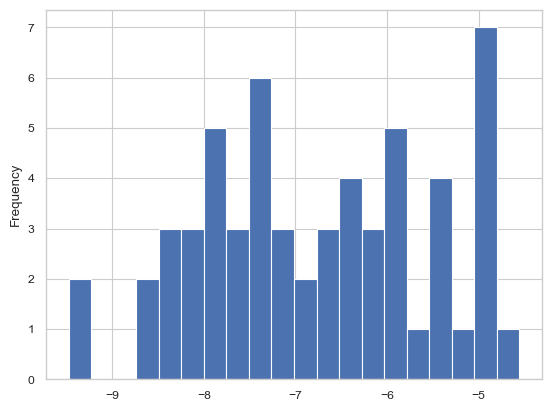

In [ ]:
df.columns
var = 'parent_ar_slope_mean'
df[var].apply(np.log).plot(kind='hist', bins=20)
# shapiro wilk test for normality on logged data
from scipy.stats import shapiro
stat, p = shapiro(df[var].apply(np.log))
print('Statistics=%.3f, p=%.3f' % (stat, p))
#interpret in meaningful language
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    


In [ ]:
df_clean = df.drop(['Unnamed: 2','XGB_depth_mean', 'XGB_depth_min', 'XGB_depth_max',
       'se_min1', 'se_min2', 'se_min3', 'se_mean1', 'se_mean2', 'se_mean3', 'superelevation_mean_min',
       'superelevation_mean_mean', 'superelevation_max_mean', 'superelevation', 'wt_pc_schumm', 'XV_mean_error',
       'parent_ar_slope_mean_error', 'log_gamma', 'gamma', 'log_XV_mean_SE',
       'log_parent_ar_slope_mean_SE', 'log_gamma_error', ], axis=1)
column_data_types = {
    'Avulsion Name': str,  
    'geometry': object,
    '# ICESAT MEASUREMENTS': int,  
    '# FABDEM MEASUREMENTS': int,  
    'method used': int,
    'dist_mtn_front_to_avulsion': float,  
    'total_transport distance': float,
    'normalized_dist': float,
    'Geomorphology': str,
    'XV1': float,  
    'XV2': float,  
    'XV3': float,  
    'XV_mean': float,  
    'parent_ar_slope1': float, 
    'parent_ar_slope2': float,  
    'parent_ar_slope3': float,  
    'alluvial_ridge_elevation1': float,  
    'floodplain_elevation1': float,  
    'water_elevation1': float, 
    'alluvial_ridge_elevation2': float,  
    'floodplain_elevation2': float,  
    'water_elevation2': float,  
    'alluvial_ridge_elevation3': float,  
    'floodplain_elevation3': float,  
    'water_elevation3': float,  
    'width': float, 
    'discharge_min': float,  
    'discharge_mean': float,  
    'discharge_max': float,  
    'se_max1': float,  
    'se_max2': float, 
    'se_max3': float, 
    'se_std': float,  
    'parent_ar_slope_mean': float, 
    'XS/DS': float,
    'sp': float,  
    'gamma_error_upper': float,
    'gamma_error_lower': float,
    'aspect ratio': float,
    'corrected_discharge': float,
    'XGB_depth': float,
    'alluvial_ridge_height1': float,
    'alluvial_ridge_height2': float,
    'alluvial_ridge_height3': float,
    'A': float,  
    'B': float,  
    'A1': float,  
    'B1': float,  
    'A2': float,  
    'B2': float,  
    'A3': float,  
    'B3': float,  
    'A/B': float,  
    'superelevation_ov_mean': float,  
    'superelevation_sem': float,  
    'prod': float,  
    'AB_flag': str,  
    'uncertainty': float  
}
df_clean = df_clean.astype(column_data_types)

column_name_mapping = {
    'Avulsion Name': 'Avulsion Name',
    'geometry': 'geometry',
    '# ICESAT MEASUREMENTS': 'num_icesat_measurements',
    '# FABDEM MEASUREMENTS': 'num_fabdem_measurements',
    'method used': 'method_used',
    'dist_mtn_front_to_avulsion': 'dist_mtn_front_to_avulsion_m',
    'total_transport distance': 'total_transport_distance_m',
    'normalized_dist': 'normalized_distance',
    'Geomorphology': 'geomorphology',
    'XV1': 'sar1',
    'XV2': 'sar2',
    'XV3': 'sar3',
    'XV_mean': 'sar_mean',
    'parent_ar_slope1': 'sm1',
    'parent_ar_slope2': 'sm2',
    'parent_ar_slope3': 'sm3',
    'alluvial_ridge_elevation1': 'are1_m',
    'floodplain_elevation1': 'fpe1_m',
    'water_elevation1': 'wse1_m',
    'alluvial_ridge_elevation2': 'are2_m',
    'floodplain_elevation2': 'fpe2_m',
    'water_elevation2': 'wse2_m',
    'alluvial_ridge_elevation3': 'are3_m',
    'floodplain_elevation3': 'fpe3_m',
    'water_elevation3': 'wse3_m',
    'width': 'width_m',
    'discharge_min': 'discharge_min_cms',
    'discharge_mean': 'discharge_mean_cms',
    'discharge_max': 'discharge_max_cms',
    'se_max1': 'se_1',
    'se_max2': 'se_2',
    'se_max3': 'se_3',
    'se_std': 'se_std',
    'parent_ar_slope_mean': 'sm_mean',
    'XS/DS': 'gamma',
    'sp': 'spr',
    'gamma_error_upper': 'gamma_error_upper',
    'gamma_error_lower': 'gamma_error_lower',
    'aspect ratio': 'aspect_ratio',
    'corrected_discharge': 'corrected_discharge',
    'XGB_depth': 'xgb_depth',
    'alluvial_ridge_height1': 'har1_m',
    'alluvial_ridge_height2': 'har2_m',
    'alluvial_ridge_height3': 'har3_m',
    'A': 'a',
    'B': 'b',
    'A1': 'a1',
    'B1': 'b1',
    'A2': 'a2',
    'B2': 'b2',
    'A3': 'a3',
    'B3': 'b3',
    'A/B': 'a_over_b',
    'superelevation_ov_mean': 'beta',
    'superelevation_sem': 'beta_sem',
    'prod': 'lambda',
    'AB_flag': 'ab_flag',
    'uncertainty': 'beta_uncertainty'
}
df_clean = df_clean.rename(columns=column_name_mapping)
df_clean




,Avulsion Name,geometry,num_icesat_measurements,num_fabdem_measurements,method_used,method_used2,dist_mtn_front_to_avulsion_m,total_transport_distance_m,normalized_distance,geomorphology,...,a2,b2,a3,b3,a_over_b,beta,beta_sem,lambda,ab_flag,beta_uncertainty
0,A002,POINT (-73.76116 4.04425),0,3,2,3,1200.0,1787150.000,0.000671,Fan,...,8.00,0.161318,8.00,0.161318,49.591434,1.347821,0.040843,1.156070,True,0.188682
1,A004,POINT (-73.394282 3.976931),0,3,2,3,42892.0,1792545.000,0.023928,Fan,...,3.00,0.100000,3.00,0.100000,30.000000,0.580645,0.044767,0.183767,True,0.229006
2,A012,POINT (-72.03524 7.49524),2,1,3,1,458588.0,1448956.000,0.316495,Alluvial Plain,...,2.70,10.926754,3.00,10.926754,0.204391,0.183037,0.005284,3.992620,False,0.032390
3,A018,POINT (-73.834088 3.761262),0,3,2,2,9827.0,2261252.155,0.004346,Fan,...,2.00,1.419725,2.00,1.419725,1.408723,1.166667,0.055556,0.560222,True,0.273784
4,AFR0211_1998,POINT (13.4899897969271 -12.4504207595308),2,1,1,1,7304.0,9426.000,0.774878,Delta,...,2.65,10.974293,2.65,10.974293,0.259698,0.179207,0.019554,0.449764,False,0.086145
5,ANGO2_2003,POINT (13.078039097642 -12.8841118948639),0,3,1,3,12690.0,30020.000,0.422718,Delta,...,2.24,1.128515,2.25,1.128515,1.990817,0.976664,0.012447,0.921381,True,0.156790
6,ARG_001_2001,POINT (-65.1122559275333 -27.4264093313781),2,1,1,1,85812.0,104580.000,0.820539,Delta,...,1.75,4.079862,1.75,4.079862,0.449362,0.755745,0.018014,5.554267,False,0.125485
7,B1,POINT (-62.9795 -17.0815),1,2,2,2,272652.0,3803124.369,0.071692,Fan,...,4.70,3.446485,4.71,3.446485,1.381534,1.149312,0.097552,3.821917,True,0.416583
8,B10,POINT (-65.2038 -16.2728),0,3,1,1,99648.0,3322367.305,0.029993,Alluvial Plain,...,5.00,11.282391,5.00,11.282391,0.443168,0.513189,0.026695,7.151179,False,0.117040
9,B12,POINT (-65.859 -15.879),2,1,3,3,54520.0,3327891.000,0.016383,Alluvial Plain,...,8.00,4.823134,8.00,4.823134,1.658672,0.831830,0.019004,11.136029,True,0.087324


In [ ]:
df_clean.to_excel('submission_data_final.xlsx')

In [ ]:
df_clean['lambda'].median()


1.920123766629156